# IS318 - Machine learning

## TP4 (durée 1h20)

L'objectif de ce TP est d'illustrer vos connaissances et compétences en *machine learning* en les mettant en pratique sur un jeu de données.
Il s'agira de prendre en main le jeu de données, d'appliquer des algorithmes d'apprentissage et d'essayer d'obtenir les meilleurs résultats possible sur un ensemble de test caché.

Comme pour les précédents TP, l'essentiel de l'évaluation portera sur la qualité de votre démarche méthodologique et la clarté de vos explications. Quelques points seront attribués en fonction des résultats obtenus sur l'ensemble de test, mais la rigueur de votre approche et la justification de vos choix resteront primordiales.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

X = np.load('X.npy')
y = np.load('y.npy')

## 1. Jeu de données (~10 min)

**(Question)** Explorez le jeu de données. Proposez une visualisation de quelques échantillons du jeu de données. Expliquez brièvement ce que les données représentent et comment elles sont organisées. Que remarquez-vous ?

In [78]:
X.shape

(2000, 28, 28)

In [79]:
y.shape

(2000,)

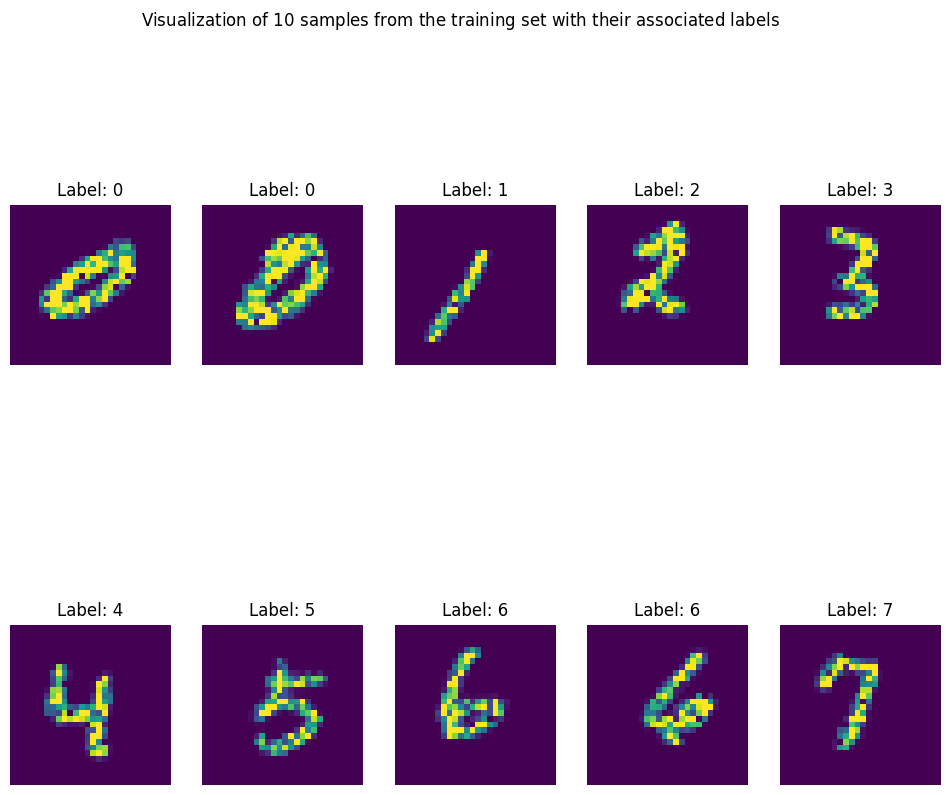

In [80]:
n_samples = 10
fig, axes = plt.subplots(2, 5, figsize=(12,10))

for i in range(n_samples):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    ax.imshow(X[i*150])
    ax.set_title(f"Label: {y[i*150]}")
    ax.axis('off')

plt.suptitle(r'Visualization of $10$ samples from the training set with their associated labels')
plt.show()

Looking these data, we see that the dataset is similar to the MNIST one, containing digits from $0$ to $9$. These are set in order (i.e., the $0$, then the $1$,...).

Variable X contain the 'drafts' of the digits (some are printed above), while variable y contains the label associated to each image.

For training, we have $2000$ images, of dimension $28 \times 28$.

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
X_train.shape

(1600, 28, 28)

In [3]:
X_train = X_train.reshape(1600, -1)

In [84]:
X_train.shape

(1600, 784)

In [4]:
X_test = X_test.reshape(400, -1)

In [86]:
y_test.shape

(400,)

## 2. Algorithme d'apprentissage (~20 min)

**(Question)** Choisissez un algorithme d'apprentissage approprié et appliquez-le pour obtenir un premier résultat de référence.
Expliquez brièvement comment cet algorithme fonctionne pour ce problème, et montrez ce qu'il a appris.
Rapportez, analysez et discutez les résultats.

Th Random Forest Classifier works as follow:
* Will  build several Decision Trees. A Decision Tree starts with the root of the tree and follow splits based on variable outcomes until a leaf node is reached and the result is given.
* It is a part of Ensemble learning, meaning that it uses multiple models, trained over the same data, averaging the results of each model ultimately, based on the hope that each tree is independent and different from tree to tree. 
* It uses bootstrapping so, it will randomly sample subsets of a dataset over a given number of iterations and a given number of variables. These results are then averaged together to obtain a more powerful result.

In [87]:
basic_RF = RandomForestClassifier()
basic_RF.fit(X_train, y_train)
basic_RF_pred = basic_RF.predict(X_test)

basic_RF_train_score = basic_RF.score(X_train, y_train)
basic_RF_test_score = basic_RF.score(X_test, y_test)

print(f"Training score: {basic_RF_train_score}")
print(f"Testing score: {basic_RF_test_score}")
print("Accuracy:", (len(y_test[y_test == basic_RF_pred]) / len(y_test)) * 100)

Training score: 1.0
Testing score: 0.76
Accuracy: 76.0


This first algorithm, launched without hyperparameter set (default: 100 estimators and no maximum depth) reach a perfect training score. This score is called $R^2$ (the coefficient of determination) and is defined as $\frac{\sum (y_{true} - y_{pred})^2}{\sum (y_{true} - mean(y_{true}))^2}$. Physically, it can be seen as the proportion of the total variation in the observed data that is captured by the model. An $R^2$ of $1$ indicates perfect prediction, while an $R^2$ of $0$ means the model explains none of the variance, and all variation is due to noise or unexplained factors.

Having this score, we know that our model is perfectly predicting the training set so we could think that it is great. But then, we see that the score on the testing set drastically decreases to $0.76$ leading to an accuracy of classification of $76\%$.With these results, it is quiet clear that the model we build has overfitted the data (it can be explained since the training dataset is quiet small).

**(Question)** Optimisez les hyperparamètres de votre modèle en utilisant un protocole approprié.
Rapportez, analysez et discutez les résultats.

I decided to tune the hyperparameters using the GridSearch method from sklearn. By doing so, I create a sort of matrix of parameters (in 2D because I have $2$ hyperparameters to tune), with each cell of the matrix containng a different combinaison of parameters (for example, the upper left cell will contain n'estimators=1 and max_depth=1 and the last will contain n'estimators=290 and max_depth=29). Then, for each combinations, a model will be created and train, following a 5-fold cross validation (each model will split the data in $5$ subsets and train on the $5$ different combinations). Finally, each model is evaluated based on a score, which is the accuracy of the prediction in this case.

In the end, I return the hyperparameters that leads to the best accuracy and the accuracy associated with this 'best' model.

In [90]:
tune_rfc_model1 = RandomForestClassifier()

first_param_dist_rf = {
    'n_estimators': np.arange(1, 300, 10),
    'max_depth': np.arange(1, 30, 1),
}

random_search_rfc1 = GridSearchCV(estimator=tune_rfc_model1, param_grid=first_param_dist_rf, scoring='accuracy', cv=5, n_jobs=-1)

random_search_rfc1.fit(X_train, y_train)

print("Best Hyperparameters:", random_search_rfc1.best_params_)
print("Best Accuracy:", random_search_rfc1.best_score_)

/home/rbonhomme001/Documents/Cours/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'max_depth': 21, 'n_estimators': 251}
Best Accuracy: 0.733125


Having these first results, I fine-tuned the model to pick the best hyperparameters.

In [91]:
tune_rfc_model1 = RandomForestClassifier()

first_param_dist_rf = {
    'n_estimators': np.arange(241, 262, 1),
    'max_depth': np.arange(20, 23, 1),
}

random_search_rfc1 = GridSearchCV(estimator=tune_rfc_model1, param_grid=first_param_dist_rf, scoring='accuracy', cv=5, n_jobs=-1)

random_search_rfc1.fit(X_train, y_train)

print("Best Hyperparameters:", random_search_rfc1.best_params_)
print("Best Accuracy:", random_search_rfc1.best_score_)

/home/rbonhomme001/Documents/Cours/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'max_depth': 20, 'n_estimators': 242}
Best Accuracy: 0.73125


In [110]:
tuned_RF = RandomForestClassifier(max_depth=20, n_estimators=242)
tuned_RF.fit(X_train, y_train)
tuned_RF_pred = tuned_RF.predict(X_test)

tuned_RF_train_score = tuned_RF.score(X_train, y_train)
tuned_RF_test_score = tuned_RF.score(X_test, y_test)

print(f"Training score: {tuned_RF_train_score}")
print(f"Testing score: {tuned_RF_test_score}")
print("Accuracy:", (len(y_test[y_test == tuned_RF_pred]) / len(y_test)) * 100)

Training score: 1.0
Testing score: 0.77
Accuracy: 77.0


## 3. Évaluation comparative (~20 min)

**(Question)** Appliquez un autre algorithme d'apprentissage approprié sur le même jeu de données.
Expliquez brièvement comment cet algorithme fonctionne pour ce problème, et montrez ce qu'il a appris.
Rapportez, analysez et discutez les résultats.
Comparez-les à ceux obtenus pour le modèle précédent.

I would simply apply the Logistic Regression to our data.


No more time to explain clearly...

In [125]:
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)
y_pred_logit = logit.predict(X_test)

logit_train_score = logit.score(X_train, y_train)
logit_test_score = logit.score(X_test, y_test)

print(f"Training score: {logit_train_score}")
print(f"Testing score: {logit_test_score}")
print("Accuracy:", (len(y_test[y_test == y_pred_logit]) / len(y_test)) * 100)

Training score: 1.0
Testing score: 0.475
Accuracy: 47.5


Again a poor testing score, we surely overfit.

## 4. Amélioration des performances (~25 min)

**(Question)** Essayez d'obtenir les meilleurs résultats possibles sur ce jeu de données, en expliquant votre démarche. À défaut, suggérez des pistes d'amélioration.

Ideally, I would have learn a boosting algorithm (XGBoost) but I realized that I hadn't install the library so I couldn't use it.

Another wayof increase the accuracy could have been to use unsupervised learning to do some clustering (with KMeans fo example), but I focused on the tuning of the RandomForest algorithm and I therefore could not implement it for this dataset.

## 5. Prédictions sur l'ensemble de test (~5 min)

**(Question)** Préparez et utilisez votre meilleur modèle pour obtenir les prédictions sur l'ensemble de test (fourni à la fin du TP).
Stockez les prédictions dans le même format que les labels `y` fournis au début du TP, et enregistrez-les dans un fichier nommé `y_test_preds.npy` à l'aide de la fonction `np.save`.

In [123]:
X = X.reshape(2000, -1)
tune_rfc_model_final = RandomForestClassifier()

final_param_dist_rf = {
    'n_estimators': np.arange(1, 300, 10),
    'max_depth': np.arange(1, 30, 1),
}

random_search_rf_final = GridSearchCV(estimator=tune_rfc_model_final, param_grid=final_param_dist_rf, scoring='accuracy', cv=5, n_jobs=-1)

random_search_rf_final.fit(X, y)

print("Best Hyperparameters:", random_search_rf_final.best_params_)
print("Best Accuracy:", random_search_rf_final.best_score_)

Best Hyperparameters: {'max_depth': 19, 'n_estimators': 291}
Best Accuracy: 0.7555


In [127]:
final_rf_model = RandomForestClassifier(n_estimators=291, max_depth=19)
final_rf_model.fit(X, y)

RandomForestClassifier(max_depth=19, n_estimators=291)

In [128]:
X_test = np.load('X_test.npy')
X_test.shape

(1000, 28, 28)

In [129]:
X_test = X_test.reshape(1000, -1)

In [130]:
y_test_preds = final_rf_model.predict(X_test)

np.save('y_test_preds.npy', y_test_preds)

Vérification du format de votre fichier de prédictions :

In [131]:
y_test_preds = np.load('y_test_preds.npy')
assert y_test_preds.dtype == y.dtype
assert y_test_preds.ndim == y.ndim
assert y_test_preds.shape[0] == X_test.shape[0]

Faites une archive de votre travail avec la commande : `tar cvzf ml-tp4.tgz ml-tp4.ipynb y_test_preds.npy`

In [4]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
eval_set = [(X_test, y_test)]

In [6]:
basic_XGBClass_2 = XGBClassifier()
basic_XGBClass_2.fit(X_train, y_train, eval_set=eval_set, verbose=0)

basic_XGB_y_pred = basic_XGBClass_2.predict(X_test)


basic_XGB_2_train_score = basic_XGBClass_2.score(X_train, y_train)
basic_XGB_2_test_score = basic_XGBClass_2.score(X_test, y_test)

print(f"Training score Classifier: {basic_XGB_2_train_score}")
print(f"Testing score Classifier: {basic_XGB_2_test_score}")
print("Accuracy:", (len(y_test[y_test == basic_XGB_y_pred]) / len(y_test)) * 100)

Training score Classifier: 1.0
Testing score Classifier: 0.7275
Accuracy: 72.75


In [9]:
basic_LGBMClass = LGBMClassifier(verbose=-1)
basic_LGBMClass.fit(X_train, y_train, eval_set=eval_set)
basic_LGBM_y_pred = basic_LGBMClass.predict(X_test)

basic_LGBM_2_train_score = basic_LGBMClass.score(X_train, y_train)
basic_LGBM_2_test_score = basic_LGBMClass.score(X_test, y_test)

print(f"Training score Classifier: {basic_LGBM_2_train_score}")
print(f"Testing score Classifier: {basic_LGBM_2_test_score}")
print("Accuracy:", (len(y_test[y_test == basic_LGBM_y_pred]) / len(y_test)) * 100)

Training score Classifier: 1.0
Testing score Classifier: 0.755
Accuracy: 75.5


In [2]:
from sklearn.preprocessing import StandardScaler

X = X.reshape(2000, -1)
# Standardize the numerical data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

In [3]:
scaled_RF = RandomForestClassifier()
scaled_RF.fit(X_train, y_train)
scaled_RF_pred = scaled_RF.predict(X_test)

scaled_RF_train_score = scaled_RF.score(X_train, y_train)
scaled_RF_test_score = scaled_RF.score(X_test, y_test)

print(f"Training score: {scaled_RF_train_score}")
print(f"Testing score: {scaled_RF_test_score}")
print("Accuracy:", (len(y_test[y_test == scaled_RF_pred]) / len(y_test)) * 100)

Training score: 1.0
Testing score: 0.735
Accuracy: 73.5
